In [ ]:
!unzip -q /content/my_dataset.zip -d /content/

In [ ]:
import os
import random
import shutil
from pathlib import Path

# Paths
base_path = Path("/content/my_dataset")
images_path = base_path / "images"
labels_path = base_path / "labels"

# Output folders
for split in ["train", "val"]:
    (base_path / "images" / split).mkdir(parents=True, exist_ok=True)
    (base_path / "labels" / split).mkdir(parents=True, exist_ok=True)

# Get all image files
image_files = list(images_path.glob("*.jpg")) + list(images_path.glob("*.jpeg")) + list(images_path.glob("*.png"))

# Shuffle
random.shuffle(image_files)

# Train/val split (80% train, 20% val)
split_idx = int(len(image_files) * 0.8)
train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

def move_files(file_list, split):
    for img_path in file_list:
        # Move image
        shutil.copy(img_path, base_path / "images" / split)

        # Move label if exists
        label_file = labels_path / (img_path.stem + ".txt")
        if label_file.exists():
            shutil.copy(label_file, base_path / "labels" / split)

# Run splitting
move_files(train_files, "train")
move_files(val_files, "val")

print("✅ Split complete.")
print(f"Train: {len(train_files)} images")
print(f"Val: {len(val_files)} images")

✅ Split complete.
Train: 272 images
Val: 69 images


In [ ]:
train_images = list((base_path / "images" / "train").glob("*.*"))
val_images = list((base_path / "images" / "val").glob("*.*"))

missing_train = [img.name for img in train_images if not (base_path / "labels/train" / (img.stem + ".txt")).exists()]
missing_val = [img.name for img in val_images if not (base_path / "labels/val" / (img.stem + ".txt")).exists()]

print(f"Train images: {len(train_images)}, Train labels: {len(train_images) - len(missing_train)}")
print(f"Val images: {len(val_images)}, Val labels: {len(val_images) - len(missing_val)}")

print(f"⚠️ Missing labels in train: {len(missing_train)}")
print(f"⚠️ Missing labels in val: {len(missing_val)}")


Train images: 322, Train labels: 93
Val images: 119, Val labels: 37
⚠️ Missing labels in train: 229
⚠️ Missing labels in val: 82


In [ ]:
import os
from pathlib import Path

base_path = Path("/content/my_dataset")

def clean_split(split):
    img_dir = base_path / "images" / split
    lbl_dir = base_path / "labels" / split
    removed = 0
    for img in img_dir.glob("*.*"):
        if not (lbl_dir / (img.stem + ".txt")).exists():
            os.remove(img)
            removed += 1
    print(f"Removed {removed} unlabeled images from {split}")

clean_split("train")
clean_split("val")


Removed 229 unlabeled images from train
Removed 82 unlabeled images from val


In [ ]:
import os
from collections import defaultdict

# Configuration
CLASS_NAME = 'fish'
CLASS_ID = 0   # ✅ your class is ID 0, not 1
DATASET_ROOT = '/content/my_dataset'

# ========== 1. Label Analysis ==========
def analyze_labels(label_path, set_name):
    """Analyze label files and count class instances."""
    class_counts = defaultdict(int)

    if not os.path.exists(label_path):
        raise FileNotFoundError(f"{set_name} labels not found at: {label_path}")

    print(f"\nAnalyzing {set_name} labels in: {label_path}")
    for label_file in os.listdir(label_path):
        if not label_file.endswith('.txt'):
            continue

        with open(os.path.join(label_path, label_file)) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:  # class_id + at least 4 coords
                    class_id = int(parts[0])
                    class_counts[class_id] += 1

    return class_counts

# Analyze both train and val sets
train_counts = analyze_labels(os.path.join(DATASET_ROOT, 'labels', 'train'), 'Train')
val_counts = analyze_labels(os.path.join(DATASET_ROOT, 'labels', 'val'), 'Validation')

# ========== 2. Class Verification ==========
print("\nClass Distribution Summary:")
print(f"Train set: Class {CLASS_ID} instances = {train_counts.get(CLASS_ID, 0)}")
print(f"Val set: Class {CLASS_ID} instances = {val_counts.get(CLASS_ID, 0)}")

if CLASS_ID not in train_counts:
    raise ValueError(f"ERROR: Class ID {CLASS_ID} ({CLASS_NAME}) not found in training labels!")
if CLASS_ID not in val_counts and val_counts:  # Only warn if val set exists but has no class
    print(f"WARNING: Class ID {CLASS_ID} not found in validation labels!")

# ========== 3. Generate YOLOv8-Compatible YAML ==========
yaml_content = f"""path: {DATASET_ROOT}  # Root path (MUST come first)
train: images/train  # Relative to 'path'
val: images/val      # Relative to 'path'
nc: 1                # Number of classes
names: ['{CLASS_NAME}']  # Class names list

# Segmentation-specific (recommended)
mask_ratio: 4        # Downsample ratio for masks
overlap_mask: True   # Allow overlapping masks
"""

yaml_path = os.path.join(DATASET_ROOT, 'data.yaml')
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

# ========== 4. Simplified Path Verification ==========
print(f"\nGenerated YAML at: {yaml_path}")
print("Contents:")
print(yaml_content)

print("\nPath Verification:")
def check_path(rel_path):
    full_path = os.path.join(DATASET_ROOT, rel_path)
    exists = os.path.exists(full_path)
    count = len(os.listdir(full_path)) if exists else 0
    print(f"{'✓' if exists else '✗'} {rel_path}: {count} files")

check_path('images/train')
check_path('images/val')
check_path('labels/train')
check_path('labels/val')



Analyzing Train labels in: /content/my_dataset/labels/train

Analyzing Validation labels in: /content/my_dataset/labels/val

Class Distribution Summary:
Train set: Class 0 instances = 13
Val set: Class 0 instances = 18

Generated YAML at: /content/my_dataset/data.yaml
Contents:
path: /content/my_dataset  # Root path (MUST come first)
train: images/train  # Relative to 'path'
val: images/val      # Relative to 'path'
nc: 1                # Number of classes
names: ['fish']  # Class names list

# Segmentation-specific (recommended)
mask_ratio: 4        # Downsample ratio for masks
overlap_mask: True   # Allow overlapping masks


Path Verification:
✓ images/train: 93 files
✓ images/val: 37 files
✓ labels/train: 93 files
✓ labels/val: 37 files


In [ ]:
yaml_content = """
train: /content/my_dataset/images/train
val: /content/my_dataset/images/val

nc: 1
names: ['fish']
"""
with open("/content/my_dataset/data.yaml", "w") as f:
    f.write(yaml_content)

print("✅ data.yaml written at /content/my_dataset/data.yaml")


✅ data.yaml written at /content/my_dataset/data.yaml


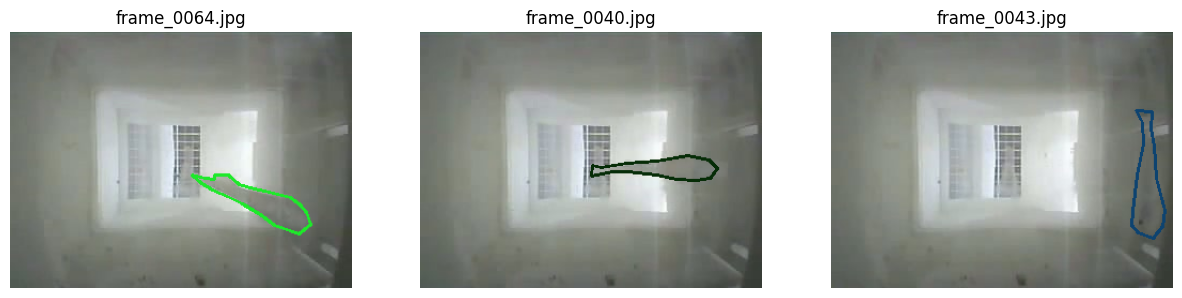

In [ ]:
# polygon_visualization.py
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

def visualize_polygons(dataset_root='/content/my_dataset', num_samples=3):
    img_dir = os.path.join(dataset_root, 'images', 'train')
    label_dir = os.path.join(dataset_root, 'labels', 'train')

    # Get all image files with corresponding labels
    valid_images = []
    for img_file in os.listdir(img_dir):
        base_name = os.path.splitext(img_file)[0]
        label_path = os.path.join(label_dir, f"{base_name}.txt")
        if os.path.exists(label_path):
            valid_images.append(img_file)

    num_samples = min(num_samples, len(valid_images))
    if num_samples == 0:
        print("❌ No labeled images found!")
        return

    # Randomly pick samples
    sampled_images = random.sample(valid_images, num_samples)

    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(sampled_images):
        base_name = os.path.splitext(img_file)[0]
        img_path = os.path.join(img_dir, img_file)
        label_path = os.path.join(label_dir, f"{base_name}.txt")

        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        with open(label_path) as f:
            lines = f.readlines()

        # Draw polygons
        for line in lines:
            parts = line.strip().split()
            if len(parts) < 6:
                continue  # not a valid polygon
            coords = np.array(list(map(float, parts[1:])))
            polygon = coords.reshape(-1, 2) * [w, h]

            color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
            cv2.polylines(img, [polygon.astype(int)], True, color, 2)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(img_file)
        plt.axis('off')

    plt.show()

if __name__ == "__main__":
    visualize_polygons()


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
results = model.train(
    data="/content/my_dataset/data.yaml",
    epochs=100,
    imgsz=240,
    batch=16,
    name="fish_320x240",
    augment=True,
)


Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/my_dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=240, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fish_320x240, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pr

train: Scanning /content/my_dataset/labels/train... 93 images, 0 backgrounds, 80 corrupt: 100%|██████████| 93/93 [00:00<00:00, 2421.46it/s]

train: /content/my_dataset/images/train/frame_0001.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/my_dataset/images/train/frame_0002.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/my_dataset/images/train/frame_0003.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/my_dataset/images/train/frame_0005.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/my_dataset/images/train/frame_0006.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/my_dataset/images/train/frame_0007.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/my_dataset/images/


val: Scanning /content/my_dataset/labels/val... 37 images, 0 backgrounds, 19 corrupt: 100%|██████████| 37/37 [00:00<00:00, 1161.61it/s]

val: /content/my_dataset/images/val/frame_0004.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/my_dataset/images/val/frame_0018.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/my_dataset/images/val/frame_0022.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/my_dataset/images/val/frame_0026.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/my_dataset/images/val/frame_0029.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/my_dataset/images/val/frame_0032.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/my_dataset/images/val/frame_0034.jpg: ignori

Plotting labels to runs/segment/fish_320x240/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 0 dataloader workers
Logging results to runs/segment/fish_320x240
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G       3.06      5.152      3.964       2.49         22        256: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

                   all         18         18          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      3.235      5.401      3.913      2.632         21        256: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         18         18          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      3.009      5.397      3.913      2.407         27        256: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         18         18          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      3.243      5.247      3.928      2.412         29        256: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         18         18          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      3.629      4.964      3.905      2.643         22        256: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         18         18          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      3.233      4.708      3.968      2.445         25        256: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         18         18          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      3.016      4.201      3.969      2.199         29        256: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         18         18          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      2.785      4.344      3.859      2.098         34        256: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         18         18          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      2.534      4.218      3.903       1.97         23        256: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         18         18          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      2.436      3.793      3.824      1.941         28        256: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         18         18          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      2.156      3.645       3.76      1.802         28        256: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         18         18          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.982      2.924      3.825       1.85         21        256: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         18         18          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      2.168      3.357      3.747      1.679         31        256: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         18         18          0          0          0          0   0.000414     0.0556   0.000226   2.26e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      2.075      2.941      3.733      1.741         27        256: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         18         18          0          0          0          0   0.000783      0.111   0.000453   6.67e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.851      2.344      3.688      1.587         24        256: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all         18         18   0.000727      0.111   0.000404   8.08e-05    0.00182      0.278    0.00125   0.000254



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.795      2.646      3.597       1.72         23        256: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         18         18    0.00387      0.667    0.00323    0.00131    0.00355      0.611    0.00334    0.00119



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.659      2.099      3.537      1.561         29        256: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         18         18    0.00463      0.889    0.00437    0.00195    0.00405      0.778    0.00494    0.00188



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.834      2.606      3.466       1.52         30        256: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

                   all         18         18    0.00463      0.889    0.00437    0.00195    0.00405      0.778    0.00494    0.00188



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.956      2.486      3.446      1.688         28        256: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         18         18    0.00427      0.889    0.00438    0.00218    0.00401      0.833    0.00621    0.00237



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.624      2.141      3.358      1.439         25        256: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         18         18    0.00427      0.889    0.00438    0.00218    0.00401      0.833    0.00621    0.00237



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.518       2.13      3.342       1.47         29        256: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

                   all         18         18    0.00368      0.833     0.0074    0.00257    0.00368      0.833     0.0114    0.00424



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.363      2.286      3.137      1.424         29        256: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         18         18    0.00368      0.833     0.0074    0.00257    0.00368      0.833     0.0114    0.00424



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.555       2.37      3.233      1.335         34        256: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all         18         18    0.00364      0.889      0.012    0.00412    0.00364      0.889     0.0174    0.00635



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G       1.51      2.169      2.986      1.497         27        256: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

                   all         18         18    0.00364      0.889      0.012    0.00412    0.00364      0.889     0.0174    0.00635



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.425      2.019      3.037      1.367         30        256: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all         18         18    0.00334      0.889     0.0171      0.008    0.00355      0.944     0.0202     0.0088



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G       1.63      2.415      2.869      1.369         29        256: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         18         18    0.00334      0.889     0.0171      0.008    0.00355      0.944     0.0202     0.0088



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.502      1.816      2.724      1.345         27        256: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

                   all         18         18    0.00326      0.889      0.222       0.14    0.00346      0.944      0.314      0.133



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.237      1.992       2.48      1.301         23        256: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         18         18    0.00326      0.889      0.222       0.14    0.00346      0.944      0.314      0.133



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.537      1.916      2.489       1.31         34        256: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         18         18      0.325      0.667      0.476      0.255      0.379      0.778      0.666      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.419      1.666      2.266      1.285         30        256: 100%|██████████| 1/1 [00:03<00:00,  3.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

                   all         18         18      0.325      0.667      0.476      0.255      0.379      0.778      0.666      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.446       1.78      2.099      1.465         22        256: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         18         18      0.561        0.5      0.531      0.295      0.692      0.556      0.678      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G       1.62        1.9      1.962      1.336         38        256: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         18         18      0.561        0.5      0.531      0.295      0.692      0.556      0.678      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.694      1.772      1.761      1.487         29        256: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all         18         18      0.485      0.577      0.588      0.308      0.863        0.5       0.69      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.456      1.685      1.516      1.296         28        256: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all         18         18      0.485      0.577      0.588      0.308      0.863        0.5       0.69      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.425      1.731      1.485      1.361         26        256: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         18         18      0.666      0.556      0.591      0.288      0.831      0.547      0.664      0.339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.399      1.701      1.334       1.37         25        256: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all         18         18      0.666      0.556      0.591      0.288      0.831      0.547      0.664      0.339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.419      1.559      1.455      1.206         30        256: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         18         18       0.64      0.611      0.621      0.287      0.717      0.564      0.672      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.522      2.022      2.134      1.408         20        256: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         18         18       0.64      0.611      0.621      0.287      0.717      0.564      0.672      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      1.446      1.856      1.645      1.289         31        256: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         18         18      0.482       0.62      0.578      0.253       0.71        0.5      0.657       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.461      1.797      1.584      1.257         23        256: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         18         18      0.482       0.62      0.578      0.253       0.71        0.5      0.657       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.467      2.163      1.694      1.386         26        256: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         18         18      0.487      0.556       0.56      0.264      0.704      0.529      0.653      0.319



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      1.377      1.542      1.218      1.207         37        256: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         18         18      0.487      0.556       0.56      0.264      0.704      0.529      0.653      0.319



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      1.215      1.622      1.386      1.244         26        256: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         18         18      0.514      0.611      0.556      0.253      0.511      0.667      0.578      0.296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      1.196      1.289      1.088      1.091         30        256: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all         18         18      0.514      0.611      0.556      0.253      0.511      0.667      0.578      0.296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      1.437       1.47      1.221      1.308         30        256: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all         18         18      0.516        0.5      0.508      0.249      0.575      0.556      0.563      0.271



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G       1.18      1.536      1.205      1.138         29        256: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         18         18      0.516        0.5      0.508      0.249      0.575      0.556      0.563      0.271



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G       1.39       1.91      1.392      1.299         30        256: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

                   all         18         18      0.657        0.5      0.602      0.328      0.742      0.667      0.693      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G      1.446      1.884      1.387      1.304         30        256: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         18         18      0.657        0.5      0.602      0.328      0.742      0.667      0.693      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G      1.394      1.806      1.447      1.314         25        256: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         18         18      0.727      0.556      0.671      0.304      0.629      0.658      0.693      0.361



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G      1.247      1.264      1.291      1.277         27        256: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

                   all         18         18      0.727      0.556      0.671      0.304      0.629      0.658      0.693      0.361



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G      1.404      1.723      1.378      1.233         24        256: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         18         18      0.608      0.775      0.746      0.324      0.608      0.775      0.741      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      1.269        1.3      1.296      1.248         20        256: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         18         18      0.608      0.775      0.746      0.324      0.608      0.775      0.741      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G       1.38      1.706       1.19      1.202         29        256: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         18         18      0.608      0.775      0.746      0.324      0.608      0.775      0.741      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G       1.45        1.5      1.157      1.235         25        256: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all         18         18      0.672      0.667      0.718      0.346      0.727      0.778      0.803      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G      1.111      1.725      1.189      1.123         31        256: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all         18         18      0.672      0.667      0.718      0.346      0.727      0.778      0.803      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G      1.277      1.391      1.228      1.189         25        256: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all         18         18      0.672      0.667      0.718      0.346      0.727      0.778      0.803      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G      1.282      1.345      1.123      1.214         24        256: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         18         18      0.583      0.833      0.775      0.384      0.698      0.833      0.823      0.426



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G      1.224      1.465      1.317       1.34         21        256: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         18         18      0.583      0.833      0.775      0.384      0.698      0.833      0.823      0.426



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G      1.259      1.431      1.051      1.231         25        256: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         18         18      0.583      0.833      0.775      0.384      0.698      0.833      0.823      0.426



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G       1.21      1.268      1.186      1.178         23        256: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         18         18       0.65      0.826      0.798      0.411       0.71      0.889      0.834      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G      1.104       1.22      1.041       1.13         27        256: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         18         18       0.65      0.826      0.798      0.411       0.71      0.889      0.834      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      1.205      1.412      1.041      1.085         30        256: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all         18         18       0.65      0.826      0.798      0.411       0.71      0.889      0.834      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G       1.26      1.567      1.221      1.274         24        256: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all         18         18      0.684      0.962       0.87      0.424      0.679      0.944      0.882      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      1.113      1.357       1.13      1.159         23        256: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         18         18      0.684      0.962       0.87      0.424      0.679      0.944      0.882      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G       1.22      1.352      1.156      1.293         23        256: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

                   all         18         18      0.684      0.962       0.87      0.424      0.679      0.944      0.882      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G      1.147      1.414      1.204       1.26         22        256: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         18         18      0.607      0.944      0.838      0.395      0.651      0.828      0.837      0.456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G      1.135      1.308      1.162      1.188         20        256: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         18         18      0.607      0.944      0.838      0.395      0.651      0.828      0.837      0.456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G      1.228      1.425      1.269      1.267         22        256: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         18         18      0.607      0.944      0.838      0.395      0.651      0.828      0.837      0.456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G      1.212      1.426      1.126      1.186         24        256: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         18         18      0.627      0.833      0.828      0.382      0.627      0.833      0.826      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G       1.29      1.594      1.171      1.233         29        256: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all         18         18      0.627      0.833      0.828      0.382      0.627      0.833      0.826      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G      1.193      1.414      1.091      1.218         22        256: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         18         18      0.627      0.833      0.828      0.382      0.627      0.833      0.826      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G      1.155      1.583      1.177      1.232         18        256: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         18         18      0.706      0.944      0.853      0.377      0.706      0.944      0.852      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G      1.403      1.361      1.195      1.258         23        256: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         18         18      0.706      0.944      0.853      0.377      0.706      0.944      0.852      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G      1.154      1.458      1.208      1.218         20        256: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         18         18      0.706      0.944      0.853      0.377      0.706      0.944      0.852      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G      1.167      1.711      1.071      1.204         21        256: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         18         18      0.706      0.944      0.841      0.373      0.807      0.928      0.864      0.462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G      1.091      1.378     0.9995      1.128         34        256: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         18         18      0.706      0.944      0.841      0.373      0.807      0.928      0.864      0.462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G      1.183      1.471     0.9728      1.191         28        256: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         18         18      0.706      0.944      0.841      0.373      0.807      0.928      0.864      0.462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G      1.096      1.305     0.9962      1.173         23        256: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         18         18      0.775      0.778      0.893      0.397      0.863      0.833      0.907      0.495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G      1.126      1.531      0.992      1.142         33        256: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         18         18      0.775      0.778      0.893      0.397      0.863      0.833      0.907      0.495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G      1.037      1.188     0.9828      1.083         23        256: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         18         18      0.775      0.778      0.893      0.397      0.863      0.833      0.907      0.495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G      1.106      1.811      1.115      1.175         23        256: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         18         18      0.826      0.791      0.893      0.387      0.884      0.845      0.912      0.507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G      1.128      1.337      1.091      1.144         22        256: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         18         18      0.826      0.791      0.893      0.387      0.884      0.845      0.912      0.507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G      1.058      1.201     0.9729      1.013         28        256: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         18         18      0.826      0.791      0.893      0.387      0.884      0.845      0.912      0.507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G       1.28      1.631      1.133      1.225         30        256: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         18         18      0.828      0.801      0.889      0.369      0.885      0.855      0.919      0.526



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G      1.195      1.207     0.9729      1.172         29        256: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         18         18      0.828      0.801      0.889      0.369      0.885      0.855      0.919      0.526



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G      1.041      1.189       1.06      1.117         29        256: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         18         18      0.828      0.801      0.889      0.369      0.885      0.855      0.919      0.526



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G      1.049      1.226     0.9118      1.072         32        256: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         18         18      0.828      0.801      0.889      0.369      0.885      0.855      0.919      0.526



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G      1.099      1.319      0.998      1.131         35        256: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         18         18      0.824      0.783      0.885      0.364      0.883      0.838      0.916      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      1.069      1.586      0.901      1.068         28        256: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         18         18      0.824      0.783      0.885      0.364      0.883      0.838      0.916      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G     0.9802      1.089     0.9256      1.121         26        256: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all         18         18      0.824      0.783      0.885      0.364      0.883      0.838      0.916      0.523


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G      1.103      1.038       1.26      1.248         13        256: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         18         18      0.824      0.783      0.885      0.364      0.883      0.838      0.916      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G     0.9841      1.248      1.079      1.246         13        256: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         18         18       0.83      0.833      0.879      0.387      0.886      0.889      0.916      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G     0.9881      1.162      1.041      1.256         13        256: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         18         18       0.83      0.833      0.879      0.387      0.886      0.889      0.916      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G      1.021       1.18      1.044      1.188         13        256: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         18         18       0.83      0.833      0.879      0.387      0.886      0.889      0.916      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G      1.044      1.199      1.134      1.296         13        256: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         18         18       0.83      0.833      0.879      0.387      0.886      0.889      0.916      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G        0.9      1.192      1.005      1.172         13        256: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         18         18      0.868      0.732      0.894      0.414      0.934      0.781      0.927      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G      1.017      1.071       1.14      1.203         12        256: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         18         18      0.868      0.732      0.894      0.414      0.934      0.781      0.927      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G        1.1      1.125       1.13      1.306         13        256: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         18         18      0.868      0.732      0.894      0.414      0.934      0.781      0.927      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G      1.019      1.288      1.081      1.213         13        256: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         18         18      0.868      0.732      0.894      0.414      0.934      0.781      0.927      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G      1.019      1.102      1.078      1.171         13        256: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         18         18      0.726      0.889      0.892       0.42      0.937      0.831      0.925      0.533



100 epochs completed in 0.122 hours.
Optimizer stripped from runs/segment/fish_320x240/weights/last.pt, 6.7MB
Optimizer stripped from runs/segment/fish_320x240/weights/best.pt, 6.7MB

Validating runs/segment/fish_320x240/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


                   all         18         18      0.725      0.889      0.892      0.415      0.937      0.831      0.925      0.533
Speed: 0.4ms preprocess, 51.0ms inference, 0.0ms loss, 6.8ms postprocess per image
Results saved to runs/segment/fish_320x240


In [ ]:
from ultralytics import YOLO

# Load the best model from training
model = YOLO('runs/segment/fish_320x240/weights/best.pt')

In [ ]:
# Replace with your video path
video_path = '/content/fish_video.mp4'

# Run prediction (automatically saves output)
results = model.predict(
    source=video_path,
    conf=0.5,          # Confidence threshold
    save=True,         # Save output video
    show_labels=True,  # Display class labels
    show_conf=True,    # Display confidence scores
    line_width=2,      # Polygon line thickness
)


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/342) /content/fish_video.mp4: 192x256 1 fish, 78.4ms
video 1/1 (frame 2/342) /content/fish_video.mp4: 192x256 (no detections), 60.5ms
video 1/1 (frame 3/342) /content/fish_video.mp4: 192x256 1 fish, 53.4ms
video 1/1 (frame 4/342) /content/fish_video.mp4: 192x256 1 fish, 55.0ms
video 1/1 (frame 5/342) /content/fish_video.mp4: 192x256 1 fish, 65.6ms
video 1/1 (frame 6/342) /content/fish_video.mp4: 192x256 1 fish, 57.3ms
video 1/1 (fram

In [ ]:
!ffprobe -v error -select_streams v:0 -show_entries stream=width,height -of csv=p=0 /content/fish_video.mp4
!ffprobe -v error -select_streams v:0 -show_entries stream=width,height -of csv=p=0 /content/runs/segment/predict/fish_video.avi

320,240
320,240


In [ ]:
from google.colab import files
files.download('/content/runs/segment/predict/fish_video.avi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>